In [1]:
from torch_geometric.datasets import Planetoid
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import copy
import time 
import matplotlib.pyplot as plt
import pickle # Lokales Speichern von Objekten
import keyboard
from collections import Counter

from GNM_Toolbox.tools.tools import *
from GNM_Toolbox.gnm import *
from GNM_Toolbox.data.dataloader import *

dataset = load_dataset('Citeseer')

Found dataset on harddrive.


# Some Helping Functions

In [41]:
# Gegeben sei eine target_list (a_0, a_1, a_2, ...)
# und eine out_list ((b_0, x), (b_1, x), (b_2, x), (b_3, x), ...)
# Gesucht wird eine Liste l von Indizes, 
# sodass für i < len(target_list): abs(target_list[i] - out_list[l[i]][0]) minimal ist
def find_each_nearest(target_list, out_list):
    # Each list is expected to be sorted
    i, j = 0, 0
    result = list()
    while True:
        diff_0 = abs(target_list[i] - out_list[j][0])
        diff_1 = abs(target_list[i] - out_list[j+1][0])
        
        if diff_0 >= diff_1:
            j += 1
        elif diff_0 < diff_1:
            result.append(j)
            i += 1
        if i >= len(target_list):
            return result
        if j+1 >= len(out_list):
            while i < len(target_list):
                result.append(j)
                i += 1
            return result
            
def get_best_values_indices(targets, lambdas):
    lambdas.sort(key = lambda x: x[0])
    return find_each_nearest(targets, lambdas)

def h(x):
    a0, a1, a2, a3 = 13, 4, 15, 15
    return torch.exp(torch.sum(x, dim=1)/a0 - a1) - ((torch.sum(x, dim=1) - a2 ) / a3)
    
def pi(X, y):
    y0 = F.one_hot(y, 6)
    # y should be one-hot encoded
    a0, a1, a2 = -torch.log(torch.tensor(20.)), 1, torch.tensor([[5, 0.5, 0.2, 1, 0.5, 2]]).view((6, 1))
    return torch.sigmoid(a0 + a1 * h(X).view((-1, 1)) + y0.type(torch.float) @ a2)

def create_mask_from_pi(data, pi):
    p = pi(data.x, data.y)
    mask = torch.tensor((np.random.binomial(size = p.shape[0], n = 1, p = p) == 1))        
    return mask.bool()

def split_known_mask_into_val_and_train_mask(known, ratio=0.8):
    val_mask = torch.zeros_like(known) == 1
    train_mask = torch.zeros_like(known) == 1
    for i in range(len(known)):
        if known[i] == True:
            if np.random.binomial(1, ratio) == 1:
                train_mask[i] = True
            else:
                val_mask[i] = True
    return val_mask, train_mask

def count_classes(y, mask):
    l = np.zeros((max(y)+1))
    for yy in y[mask]:
        l[yy] += 1
    return l

def calc_variance(y, mask):
    y_distribution = count_classes(y, mask)
    return np.var(y_distribution)
        
def insert_into_list(l, item, t):
    # l list, i item to insert, target
    def diff(a, b):
        return abs(a-b)
    N = len(l)
    if N == 0:
        l.insert(0, item)
        return
    d = diff(t, item[0])
    d_0 = diff(t, l[0][0])
    if d <= d_0:
        l.insert(0, item)
        return
    for i in range(N-1):
        d_0 = diff(t, l[i][0])
        d_1 = diff(t, l[i+1][0])
        if d_0 <= d and d <= d_1:
            l.insert(i+1, item)
            return
    l.append(item)
    
def alternative_boxplot(pi_est, data, x_position=1, x_width=1):
    # data: list of floats
    # x_postition: float
    # x_width: float
    N = len(pi_est)
    mean = np.mean(pi_est)
    print('{}:{}'.format(sum([1 for d in pi_est if d > mean]), sum([1 for d in pi_est if d < mean])))
    plt.plot([x_position-x_width/2, x_position-x_width/2], [mean, mean], '-', color='grey')
    noise = np.random.rand(N)
    x_positions = x_position - x_width/2. + noise * x_width
    plt.plot(x_positions[data.y == 0], np.array(pi_est[data.y == 0]), '.', color = 'red', label='0')
    plt.plot(x_positions[data.y == 1], np.array(pi_est[data.y == 1]), '.', color = 'blue', label='1')
    plt.legend()
    

def disturb_y(y, probability): # y must have 6 classes
    y_dis = torch.zeros_like(y)
    for i in range(len(y)):
        if np.random.rand(1) < probability:
            y_dis[i] = np.random.randint(6)
        else:
            y_dis[i] = y[i]
                
    return F.one_hot(y_dis, 6)


def eval_pi(pi_true, pi_est, diff=0.01):
    pi_diff = abs(pi_true.view(pi_est.shape)-pi_est)
    pi_binar = [(p < diff) for p in pi_diff]
    return sum(pi_binar)/(1. * pi_true.shape[0])

# Setup Informations:

Citeseer Datasets consists of 6 classes.

Node distribution is as follows 249, 590, 668, 701, 596, 523.

Therefore we set new class 0 to be class 3. New class 1 is going to be the rest.

We have 3327 nodes with 3703 features each. 

Citation:
@inproceedings{nr,
     title={The Network Data Repository with Interactive Graph Analytics and Visualization},
     author={Ryan A. Rossi and Nesreen K. Ahmed},
     booktitle={AAAI},
     url={http://networkrepository.com},
     year={2015}
}

# Data Setup

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.num_classes = dataset.num_classes

# Verteilung von $pi$

torch.Size([3327])
M1 = 0.104 
M2 = 0.109 
Perc = 0.052


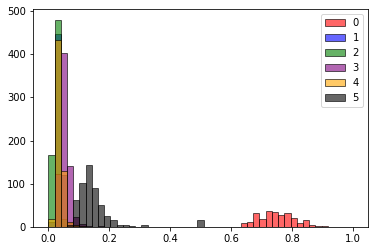

In [42]:
bins = np.linspace(0, 1, 50)
pi_true = pi(data.x, data.y)
pi_true = pi_true.view((pi_true.shape[0],))
print(pi_true.shape)
for i, color in zip(range(6), ['red', 'blue', 'green', 'purple', 'orange', 'black']):
    plt.hist(pi_true[data.y == i], bins, alpha=0.6, color=color, edgecolor='black', label='{}'.format(i));
plt.legend();
mask = create_mask_from_pi(data, pi)
print('M1 = {:.3f} \nM2 = {:.3f} \nPerc = {:.3f}'.format(torch.mean(pi_true[mask]), 
                                            torch.mean(pi_true[mask.logical_not()]),
                                            sum(mask)/(1. * len(data.y))))
#plt.figure()
#plt.hist(pi_true[(data.y == 1) & mask], bins, alpha=0.6, color='red', edgecolor='black', label='1');
#plt.hist(pi_true[(data.y == 0) & mask], bins, alpha=0.6, color='blue', edgecolor='black', label='0');

# Create 80 Train and Val Masks

In [43]:
masks1 = list()
for i in range(80):
    mask1 = create_mask_from_pi(data, pi)
    val_mask1, train_mask1 = split_known_mask_into_val_and_train_mask(mask1)
    masks1.append((None, train_mask1, val_mask1))

## Analysis

In [47]:
choosen_masks = {1: masks1}
pi_true = pi(data.x, data.y)

In [48]:
# Eval 
IT_per_mask = 2
NB_masks = len(choosen_masks[1])
M = len(choosen_masks)
t_0 = time.time()
noise_levels = [0, 0.1, 0.2, 0.4, 0.8, 1.1]
all_models = dict()
test = None

# Iteriere über Masken
for i, l in enumerate(choosen_masks):
    sms_models = list() # SM Standard
    smn_models = [list() for _ in range(len(noise_levels))] # change to len(noise_levels)
    
    for j, mask_tupel in enumerate(choosen_masks[l]):
        _, train_mask, val_mask = mask_tupel

        # Trainiere jeweils N Modelle
        for k in range(IT_per_mask):
            print_status(i * NB_masks * IT_per_mask + j * IT_per_mask + k, M * NB_masks * IT_per_mask, t_0)
            for m, noise_level in enumerate(noise_levels):
                y_noise = disturb_y(data.y, noise_level)
                pi_est, loss_list, acc_r = train_modelr3(data.x, data.y, data.num_classes, train_mask, val_mask, y_noise, expectation='other')
                
                smn_models[m].append(loss_list[-1])
                    
        all_models[l] = (smn_models)
        #pickle_write('l2_analysis-noise-1/run-{}.pkl'.format(i), all_models)
    all_models[l] = (smn_models)
    #pickle_write('l2_analysis-noise-1/run-{}.pkl'.format(i), all_models)
pickle_write('l2_analysis-citeseer-6.pkl', all_models)